# BiGRU Model for Roller Coaster Rating Prediction

This notebook trains a Bidirectional GRU model to predict roller coaster ratings from accelerometer data.

**Data Source**: Complete coaster mapping with perfect matches, duplicate averaging, and airtime calculation.

**Key Features**:
- Loads data from `complete_coaster_mapping.csv`
- Filters for perfect matches (≥95% similarity)
- Averages duplicate coaster names
- Calculates airtime features from vertical g-forces
- Trains BiGRU model with sequence + airtime features
- Full training pipeline in one notebook

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd # The import of pandas failed with an AttributeError, likely due to a corrupted installation or runtime issue. Restarting the runtime should resolve this.
import glob
import os
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Data paths
#MAPPING_CSV = 'C:/Users/hiroy/Desktop/AI_Final_Proj/complete_coaster_mapping.csv'
#RFDB_BASE_PATH = 'C:/Users/hiroy/Desktop/AI_Final_Proj/'

MAPPING_CSV = '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/complete_coaster_mapping.csv'
RFDB_BASE_PATH = '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/'

#hyper parameters
SEQUENCE_LENGTH = 100
ACCEL_CHANNELS = 3
AIRTIME_FEATURE_COUNT = 4
HIDDEN_DIM = 128            # Keep this (it provides the necessary capacity)
NUM_LAYERS = 1              # CHANGED from 2 (Reduces complexity significantly)
DROPOUT_RATE = 0.35          # INCREASED from 0.3
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
NUM_EPOCHS = 100
WEIGHT_DECAY = 2e-3         # INCREASED from 1e-5 (Key fix for the gap)
ROLLING_WINDOW_SIZE = 25


# Data filtering
MIN_CSV_COUNT = 1
MIN_RATINGS = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# DATA PREPARATION FUNCTIONS
# ============================================================================

def load_complete_mapping(csv_path=MAPPING_CSV):
    """Load the complete coaster mapping CSV."""
    if not os.path.exists(csv_path):
        print(f"[ERROR] Mapping CSV file not found at: {csv_path}")
        # You might want to raise an error or handle this more gracefully
        # For now, let's return an empty DataFrame or raise the original error
        raise FileNotFoundError(f"Mapping CSV file not found at: {csv_path}")

    df = pd.read_csv(csv_path, encoding='latin1')
    print(f"\n[OK] Loaded {len(df)} coasters from complete mapping")
    return df


def filter_by_column_al(df):
    """Filter for rows where column AL equals 1."""
    # Column AL is the 38th column (1-indexed), which is index 37 (0-indexed)
    # But it's easier to use the column name if it exists
    # Let's try to find column AL by position or name
    if 'AL' in df.columns:
        filtered = df[df['AL'] == 1].copy()
    else:
        # If column name is not 'AL', use the 38th column (index 37)
        col_name = df.columns[37] if len(df.columns) > 37 else None
        if col_name:
            filtered = df[df[col_name] == 1].copy()
        else:
            print("[!] Warning: Column AL not found, returning all rows")
            filtered = df.copy()

    print(f"[OK] Filtered to {len(filtered)} coasters where column AL = 1")
    return filtered


def get_accelerometer_files(full_path):
    """Get list of accelerometer CSV files from path."""
    # Normalize path for Windows/Unix compatibility
    full_path = full_path.replace('\\', '/')
    csv_files = glob.glob(f"{full_path}/*.csv")
    return sorted(csv_files)


def load_last_accelerometer_file(full_path):
    """Load the last CSV file from the path."""
    # Normalize path separators
    full_path = full_path.replace('\\', '/')

    csv_files = get_accelerometer_files(full_path)

    if not csv_files:
        # Try checking if path exists
        if not os.path.exists(full_path):
            print(f"[!] Path does not exist: {full_path}")
        return None

    last_file = csv_files[-1]

    try:
        df = pd.read_csv(last_file)
        return df
    except Exception as e:
        print(f"Error loading {last_file}: {e}")
        return None


def calculate_airtime(accel_df):
    """Calculate airtime statistics from accelerometer data with new features."""
    if accel_df is None or 'Vertical' not in accel_df.columns:
        return np.zeros(AIRTIME_FEATURE_COUNT, dtype=np.float32)

    vertical = accel_df['Vertical'].values
    sampling_rate = 10

    # 1. Total coaster length (in seconds)
    total_length_seconds = len(vertical) / sampling_rate

    # 2. Floater Airtime: -0.25 <= vertical_accel <= 0.25
    floater_airtime_mask = (vertical >= -0.25) & (vertical <= 0.25)
    floater_airtime_samples = np.sum(floater_airtime_mask)

    # 3. Flojector Airtime: -0.75 <= vertical_accel < -0.25
    flojector_airtime_mask = (vertical >= -0.75) & (vertical < -0.25)
    flojector_airtime_samples = np.sum(flojector_airtime_mask)

    # 4. Ejector Airtime: vertical_accel < -0.75
    ejector_airtime_mask = (vertical < -0.75)
    ejector_airtime_samples = np.sum(ejector_airtime_mask)

    return np.array([total_length_seconds, floater_airtime_samples, flojector_airtime_samples, ejector_airtime_samples], dtype=np.float32)

def apply_rolling_average_to_df(df, columns, window_size=ROLLING_WINDOW_SIZE):
    """
    Applies a rolling average filter to specified columns of a DataFrame.
    """
    df_filtered = df.copy()
    for col in columns:
        df_filtered[col] = df_filtered[col].rolling(window=window_size, min_periods=1).mean()
    return df_filtered

def prepare_training_data(mapping_csv=MAPPING_CSV, rfdb_base_path=RFDB_BASE_PATH, min_csv_count=MIN_CSV_COUNT, min_ratings=MIN_RATINGS):
    """Prepare complete training dataset from mapping CSV."""
    print("\n" + "="*70)
    print("PREPARING TRAINING DATA FROM COMPLETE MAPPING")
    print("="*70)

    df = load_complete_mapping(mapping_csv)
    df = filter_by_column_al(df)

    # Prepend the RFDB_BASE_PATH to the 'full_path' column
    df['full_path'] = df['full_path'].apply(lambda x: os.path.join(rfdb_base_path, x))

    df = df[df['csv_count'] >= min_csv_count]
    print(f"[OK] Filtered to {len(df)} coasters with >={min_csv_count} CSV files")

    #df = df[df['total_ratings'] >= min_ratings]
    #print(f"[OK] Filtered to {len(df)} coasters with >={min_ratings} total ratings")

    #df = aggregate_duplicates(df)
    df = df.sort_values('avg_rating', ascending=False)

    print("\n" + "="*70)
    print("DATASET STATISTICS")
    print("="*70)
    print(f"Total coasters: {len(df)}")
    print(f"Rating range: {df['avg_rating'].min():.2f} - {df['avg_rating'].max():.2f}")
    print(f"Average rating: {df['avg_rating'].mean():.2f} +/- {df['avg_rating'].std():.2f}")
    print(f"Total CSV files: {df['csv_count'].sum()}")
    print(f"Average CSVs per coaster: {df['csv_count'].mean():.2f}")

    df = filter_by_column_al(df)
    for _, row in df.head(5).iterrows():
        print(f"  {row['coaster_name']:30s} {row['avg_rating']:.2f}* ({row['csv_count']} CSVs)")

    print("\nBottom 5 lowest rated:")
    for _, row in df.tail(5).iterrows():
        print(f"  {row['coaster_name']:30s} {row['avg_rating']:.2f}* ({row['csv_count']} CSVs)")

    return df


    df = df.sort_values('avg_rating', ascending=False)

Using device: cuda


In [3]:
# Load and prepare the dataset
coaster_mapping = prepare_training_data(rfdb_base_path=RFDB_BASE_PATH)

print(f"\n[OK] Ready to train on {len(coaster_mapping)} coasters")


PREPARING TRAINING DATA FROM COMPLETE MAPPING

[OK] Loaded 1299 coasters from complete mapping
[OK] Filtered to 638 coasters where column AL = 1
[OK] Filtered to 638 coasters with >=1 CSV files

DATASET STATISTICS
Total coasters: 638
Rating range: 1.01 - 4.90
Average rating: 3.17 +/- 0.94
Total CSV files: 1908
Average CSVs per coaster: 2.99
[OK] Filtered to 638 coasters where column AL = 1
  Zadra                          4.90* (1 CSVs)
  AlpenFury                      4.88* (5 CSVs)
  Taiga                          4.87* (4 CSVs)
  VelociCoaster                  4.86* (5 CSVs)
  Batman Gotham City Escape      4.86* (5 CSVs)

Bottom 5 lowest rated:
  Euromir                        1.06* (1 CSVs)
  Cobra                          1.06* (1 CSVs)
  Mine Train                     1.06* (1 CSVs)
  Wacky Worm                     1.02* (1 CSVs)
  Sea Serpent                    1.01* (2 CSVs)

[OK] Ready to train on 638 coasters


In [4]:
def process_accelerometer_data(coaster_mapping):
    """
    Process all accelerometer files and extract features.
    Returns sequences, airtime features, and ratings.
    """
    all_sequences = []
    all_airtime_features = []
    all_ratings = []
    all_coaster_names = []

    REQUIRED_COLUMNS = ['time', 'xforce', 'yforce', 'zforce']
    ACCEL_COLUMNS = ['xforce', 'yforce', 'zforce']

    skipped_count = 0
    processed_count = 0

    print("\n" + "="*70)
    print("PROCESSING ACCELEROMETER DATA")
    print("="*70)

    for idx, row in coaster_mapping.iterrows():
        coaster_name = row['coaster_name']
        full_path = row['full_path'].replace('\\','/')
        rating = row['avg_rating']

        # Load accelerometer data
        accel_df = load_last_accelerometer_file(full_path)

        if accel_df is None:
            skipped_count += 1
            print(f"[!] Skipped '{coaster_name}': Could not load any valid CSV from '{full_path}'")
            continue

        # Check for required columns
        missing_cols = [col for col in REQUIRED_COLUMNS if col not in accel_df.columns]
        if missing_cols:
            skipped_count += 1
            print(f"[!] Skipped '{coaster_name}': Missing required columns {missing_cols} in files from '{full_path}'")
            continue

        # Convert to numeric and drop NaN
        for col in REQUIRED_COLUMNS:
            accel_df[col] = pd.to_numeric(accel_df[col], errors='coerce')
        accel_df = accel_df.dropna(subset=REQUIRED_COLUMNS)

        # Store raw data for comparison if needed
        raw_data_accel = accel_df[ACCEL_COLUMNS].values.copy()

        # Apply rolling average to accelerometer columns
        accel_df_processed = apply_rolling_average_to_df(accel_df, ACCEL_COLUMNS)

        if len(accel_df_processed) < SEQUENCE_LENGTH:
            skipped_count += 1
            print(f"[!] Skipped '{coaster_name}': Insufficient data length ({len(accel_df_processed)} rows) in files from '{full_path}' (min required: {SEQUENCE_LENGTH})")
            continue

        # Calculate airtime features (using filtered data)
        accel_df_processed['Vertical'] = accel_df_processed['zforce'] # Assuming 'zforce' is vertical
        airtime_features = calculate_airtime(accel_df_processed)

        # Extract acceleration sequences from filtered data
        data = accel_df_processed[ACCEL_COLUMNS].values.T  # Shape: (3, num_timesteps)

        # Normalize (subtract 1g from vertical, divide all by 5g)

        vertical_col_idx = ACCEL_COLUMNS.index('yforce') # 'yforce' is Vertical
        data[vertical_col_idx, :] = data[vertical_col_idx, :] - 1.0 # Subtract 1g from the vertical component
        data = data / 3.0

        # Create sequences with overlapping windows
        num_timesteps = data.shape[1]
        step_size = SEQUENCE_LENGTH // 4

        for start in range(0, num_timesteps - SEQUENCE_LENGTH + 1, step_size):
            segment = data[:, start:start + SEQUENCE_LENGTH]

            if segment.shape[1] == SEQUENCE_LENGTH:
                all_sequences.append(segment)
                all_airtime_features.append(airtime_features)
                all_ratings.append(rating)
                all_coaster_names.append(coaster_name)

        processed_count += 1
        if processed_count % 50 == 0:
            print(f"  Processed {processed_count}/{len(coaster_mapping)} coasters...")

    print(f"\n[OK] Successfully processed {processed_count} coasters")
    print(f"[!] Skipped {skipped_count} coasters (missing/invalid data)")
    print(f"[OK] Generated {len(all_sequences)} training sequences")

    # Convert to numpy arrays
    sequences = np.array(all_sequences, dtype=np.float32)  # (N, 3, seq_len)
    airtime_features = np.array(all_airtime_features, dtype=np.float32)  # (N, 4)
    ratings = np.array(all_ratings, dtype=np.float32)  # (N,)

    return sequences, airtime_features, ratings, all_coaster_names


# Process all coasters
sequences, airtime_features, ratings, coaster_names = process_accelerometer_data(coaster_mapping)

print(f"\nFinal dataset shape:")
print(f"  Sequences: {sequences.shape}")
print(f"  Airtime features: {airtime_features.shape}")
print(f"  Ratings: {ratings.shape}")


PROCESSING ACCELEROMETER DATA
  Processed 50/638 coasters...
  Processed 100/638 coasters...
  Processed 150/638 coasters...
  Processed 200/638 coasters...
  Processed 250/638 coasters...
  Processed 300/638 coasters...
  Processed 350/638 coasters...
[!] Skipped 'Dragonflier': Insufficient data length (0 rows) in files from '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/dollywood/dragonflier' (min required: 100)
  Processed 400/638 coasters...
  Processed 450/638 coasters...
  Processed 500/638 coasters...
  Processed 550/638 coasters...
[!] Skipped 'Catwoman's Whip': Insufficient data length (0 rows) in files from '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/sixflagsnewengland/catwomanswhip' (min required: 100)
[!] Skipped 'Cobra': Insufficient data length (0 rows) in files from '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/sixflagsdiscoverykingdom/cobra' (min required: 100)
  Processed 600/638 coaster

### Visualize Raw vs. Filtered Accelerometer Data for 'Steel Vengeance'

Loading data for 'Steel Vengeance' from: /content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/cedarpoint/steelvengeance


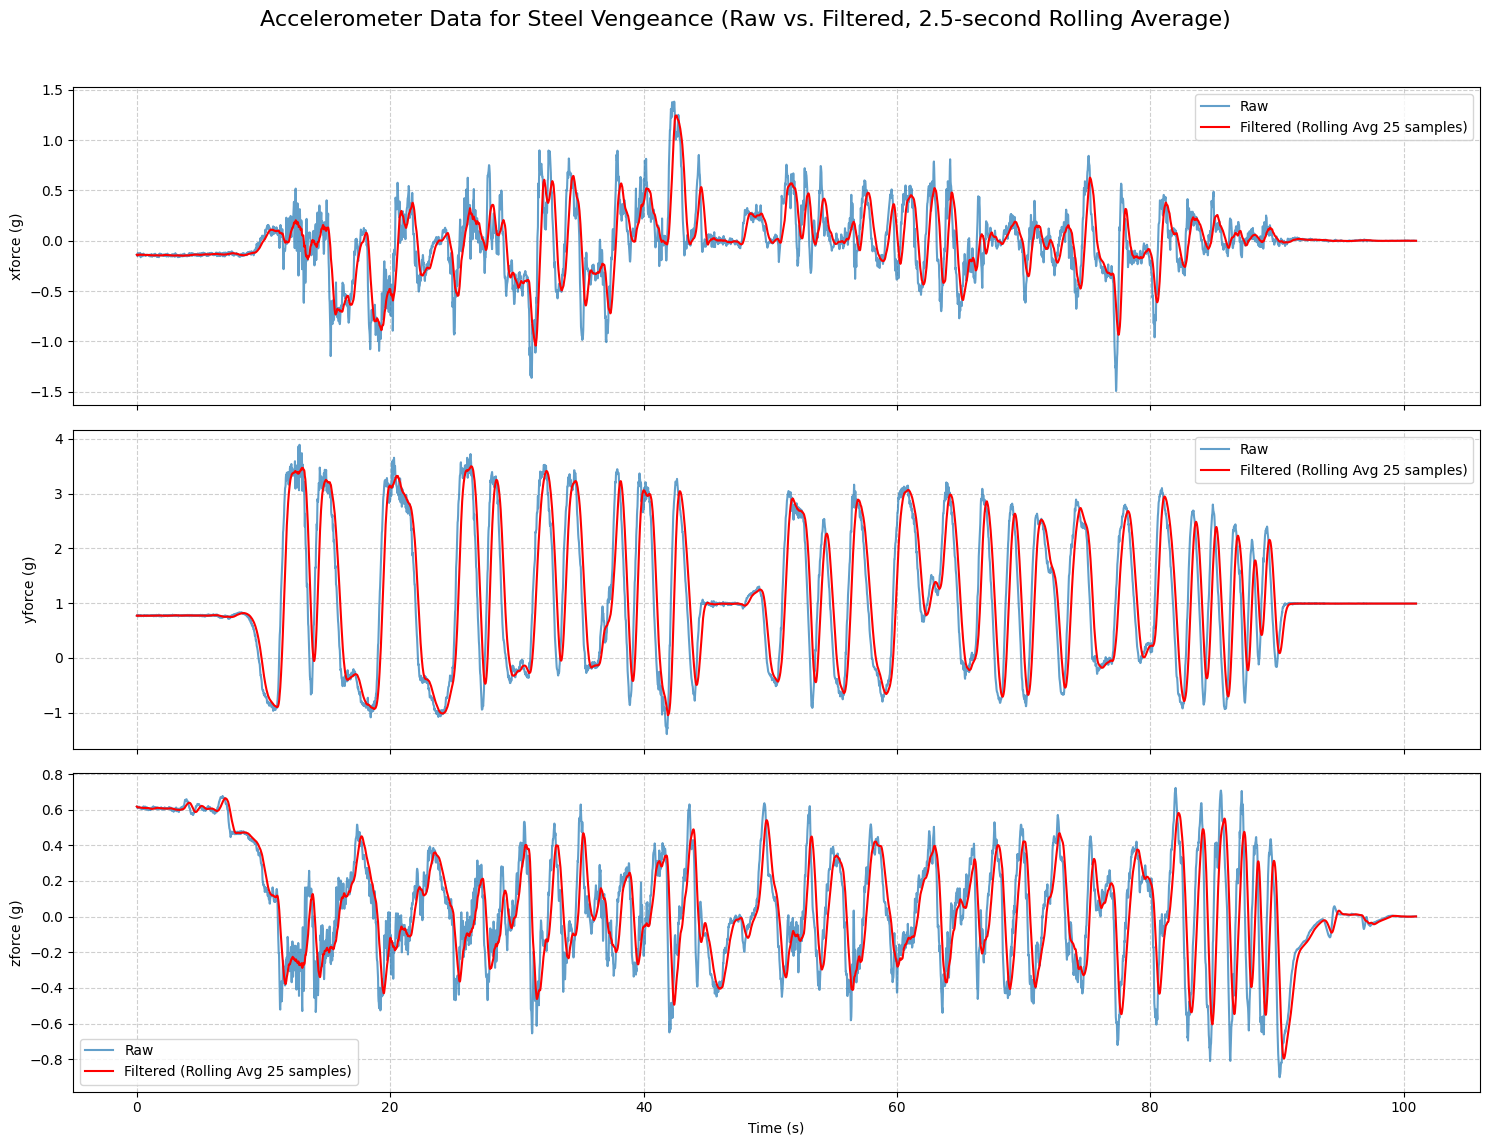

In [5]:
COASTER_TO_VISUALIZE = 'Steel Vengeance'

# Find the 'Steel Vengeance' entry in the coaster_mapping
steel_vengeance_row = coaster_mapping[coaster_mapping['coaster_name'] == COASTER_TO_VISUALIZE]

if not steel_vengeance_row.empty:
    full_path_sv = steel_vengeance_row.iloc[0]['full_path'].replace('\\','/')
    print(f"Loading data for '{COASTER_TO_VISUALIZE}' from: {full_path_sv}")

    # Load accelerometer data
    accel_df_sv = load_last_accelerometer_file(full_path_sv)

    if accel_df_sv is not None:
        REQUIRED_COLUMNS = ['time', 'xforce', 'yforce', 'zforce']
        ACCEL_COLUMNS = ['xforce', 'yforce', 'zforce']

        # Convert to numeric and drop NaN for both raw and processed data
        for col in REQUIRED_COLUMNS:
            accel_df_sv[col] = pd.to_numeric(accel_df_sv[col], errors='coerce')
        accel_df_sv = accel_df_sv.dropna(subset=REQUIRED_COLUMNS).copy()

        # Create a raw copy for plotting, including 'time'
        raw_accel_data_sv = accel_df_sv[REQUIRED_COLUMNS].copy()

        # Apply rolling average (only to ACCEL_COLUMNS, but keep 'time' for plotting)
        filtered_accel_data_sv = accel_df_sv.copy()
        filtered_accel_data_sv[ACCEL_COLUMNS] = apply_rolling_average_to_df(accel_df_sv, ACCEL_COLUMNS)[ACCEL_COLUMNS]

        # Plotting
        fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        fig.suptitle(f'Accelerometer Data for {COASTER_TO_VISUALIZE} (Raw vs. Filtered, {ROLLING_WINDOW_SIZE/10}-second Rolling Average)', fontsize=16)

        for i, col in enumerate(ACCEL_COLUMNS):
            axes[i].plot(raw_accel_data_sv['time'], raw_accel_data_sv[col], label='Raw', alpha=0.7)
            axes[i].plot(filtered_accel_data_sv['time'], filtered_accel_data_sv[col], label=f'Filtered (Rolling Avg {ROLLING_WINDOW_SIZE} samples)', color='red', linewidth=1.5)
            axes[i].set_ylabel(f'{col} (g)')
            axes[i].legend()
            axes[i].grid(True, linestyle='--', alpha=0.6)

        axes[-1].set_xlabel('Time (s)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

    else:
        print(f"[!] Could not load accelerometer data for '{COASTER_TO_VISUALIZE}'.")
else:
    print(f"[!] Coaster '{COASTER_TO_VISUALIZE}' not found in the mapping.")

## Step 1: Load and Prepare Data

Load the complete coaster mapping, filter for perfect matches, and aggregate duplicates.

In [ ]:
# Load and prepare the dataset
coaster_mapping = prepare_training_data(rfdb_base_path=RFDB_BASE_PATH)

print(f"\n[OK] Ready to train on {len(coaster_mapping)} coasters")


PREPARING TRAINING DATA FROM COMPLETE MAPPING

[OK] Loaded 1299 coasters from complete mapping
[OK] Filtered to 638 coasters where column AL = 1
[OK] Filtered to 638 coasters with >=1 CSV files

DATASET STATISTICS
Total coasters: 638
Rating range: 1.01 - 4.90
Average rating: 3.17 +/- 0.94
Total CSV files: 1908
Average CSVs per coaster: 2.99
[OK] Filtered to 638 coasters where column AL = 1
  Zadra                          4.90* (1 CSVs)
  AlpenFury                      4.88* (5 CSVs)
  Taiga                          4.87* (4 CSVs)
  VelociCoaster                  4.86* (5 CSVs)
  Batman Gotham City Escape      4.86* (5 CSVs)

Bottom 5 lowest rated:
  Euromir                        1.06* (1 CSVs)
  Cobra                          1.06* (1 CSVs)
  Mine Train                     1.06* (1 CSVs)
  Wacky Worm                     1.02* (1 CSVs)
  Sea Serpent                    1.01* (2 CSVs)

[OK] Ready to train on 638 coasters


## Step 2: Load Accelerometer Data and Extract Features

Load acceleration sequences and calculate airtime features for each coaster.

In [ ]:
def process_accelerometer_data(coaster_mapping):
    """
    Process all accelerometer files and extract features.
    Returns sequences, airtime features, and ratings.
    """
    all_sequences = []
    all_airtime_features = []
    all_ratings = []
    all_coaster_names = []

    REQUIRED_COLUMNS = ['time', 'xforce', 'yforce', 'zforce']
    ACCEL_COLUMNS = ['xforce', 'yforce', 'zforce']

    skipped_count = 0
    processed_count = 0

    print("\n" + "="*70)
    print("PROCESSING ACCELEROMETER DATA")
    print("="*70)

    for idx, row in coaster_mapping.iterrows():
        coaster_name = row['coaster_name']
        full_path = row['full_path'].replace('\\','/')
        rating = row['avg_rating']

        # Load accelerometer data
        accel_df = load_last_accelerometer_file(full_path)

        if accel_df is None:
            skipped_count += 1
            print(f"[!] Skipped '{coaster_name}': Could not load any valid CSV from '{full_path}'")
            continue

        # Check for required columns
        missing_cols = [col for col in REQUIRED_COLUMNS if col not in accel_df.columns]
        if missing_cols:
            skipped_count += 1
            print(f"[!] Skipped '{coaster_name}': Missing required columns {missing_cols} in files from '{full_path}'")
            continue

        # Convert to numeric and drop NaN
        for col in REQUIRED_COLUMNS:
            accel_df[col] = pd.to_numeric(accel_df[col], errors='coerce')
        accel_df = accel_df.dropna(subset=REQUIRED_COLUMNS)

        # Apply rolling average to accelerometer columns
        accel_df_processed = apply_rolling_average_to_df(accel_df, ACCEL_COLUMNS)

        if len(accel_df_processed) < SEQUENCE_LENGTH:
            skipped_count += 1
            print(f"[!] Skipped '{coaster_name}': Insufficient data length ({len(accel_df_processed)} rows) in files from '{full_path}' (min required: {SEQUENCE_LENGTH})")
            continue

        # Calculate airtime features (using filtered data)
        accel_df_processed['Vertical'] = accel_df_processed['zforce'] # Assuming 'zforce' is vertical
        airtime_features = calculate_airtime(accel_df_processed)

        # Extract acceleration sequences from filtered data
        data = accel_df_processed[ACCEL_COLUMNS].values.T  # Shape: (3, num_timesteps)

        # Normalize (subtract 1g from vertical, divide all by 5g)
        vertical_col_idx = ACCEL_COLUMNS.index('zforce') # Assuming 'zforce' is Vertical
        data[vertical_col_idx, :] = data[vertical_col_idx, :] - 1.0 # Subtract 1g from the vertical component
        data = data / 5.0

        # Create sequences with overlapping windows
        num_timesteps = data.shape[1]
        step_size = SEQUENCE_LENGTH // 4

        for start in range(0, num_timesteps - SEQUENCE_LENGTH + 1, step_size):
            segment = data[:, start:start + SEQUENCE_LENGTH]

            if segment.shape[1] == SEQUENCE_LENGTH:
                all_sequences.append(segment)
                all_airtime_features.append(airtime_features)
                all_ratings.append(rating)
                all_coaster_names.append(coaster_name)

        processed_count += 1
        if processed_count % 50 == 0:
            print(f"  Processed {processed_count}/{len(coaster_mapping)} coasters...")

    print(f"\n[OK] Successfully processed {processed_count} coasters")
    print(f"[!] Skipped {skipped_count} coasters (missing/invalid data)")
    print(f"[OK] Generated {len(all_sequences)} training sequences")

    # Convert to numpy arrays
    sequences = np.array(all_sequences, dtype=np.float32)  # (N, 3, seq_len)
    airtime_features = np.array(all_airtime_features, dtype=np.float32)  # (N, 4)
    ratings = np.array(all_ratings, dtype=np.float32)  # (N,)

    return sequences, airtime_features, ratings, all_coaster_names


# Process all coasters
sequences, airtime_features, ratings, coaster_names = process_accelerometer_data(coaster_mapping)

print(f"\nFinal dataset shape:")
print(f"  Sequences: {sequences.shape}")
print(f"  Airtime features: {airtime_features.shape}")
print(f"  Ratings: {ratings.shape}")


PROCESSING ACCELEROMETER DATA
  Processed 50/638 coasters...
  Processed 100/638 coasters...
  Processed 150/638 coasters...
  Processed 200/638 coasters...
  Processed 250/638 coasters...
  Processed 300/638 coasters...
  Processed 350/638 coasters...
[!] Skipped 'Dragonflier': Insufficient data length (0 rows) in files from '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/dollywood/dragonflier' (min required: 500)
  Processed 400/638 coasters...
  Processed 450/638 coasters...
[!] Skipped 'Phoenix Rising': Insufficient data length (321 rows) in files from '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/buschgardenstampa/phoenixrising' (min required: 500)
[!] Skipped 'Snoopy's Soap Box Racers': Insufficient data length (244 rows) in files from '/content/drive/MyDrive/MIT/2025-Fall/2.156 AI ML/FinalProject/rfdb_csvs/kingsisland/snoopyssoapboxracers' (min required: 500)
  Processed 500/638 coasters...
  Processed 550/638 coasters...
[!] 

## Step 3: Create Dataset and DataLoaders

Split data into train/val/test sets and create PyTorch DataLoaders.

In [6]:
class CoasterDataset(Dataset):
    """PyTorch dataset for coaster sequences and airtime features."""

    def __init__(self, sequences, airtime_features, ratings):
        self.sequences = torch.from_numpy(sequences).float()
        self.airtime_features = torch.from_numpy(airtime_features).float()
        self.ratings = torch.from_numpy(ratings).float()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.airtime_features[idx], self.ratings[idx]


# Normalize features
scaler_airtime = StandardScaler()
scaler_ratings = StandardScaler()

airtime_features_normalized = scaler_airtime.fit_transform(airtime_features)
ratings_normalized = scaler_ratings.fit_transform(ratings.reshape(-1, 1)).flatten()

# Split data: 70% train, 15% val, 15% test
indices = np.arange(len(sequences))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Create datasets
train_dataset = CoasterDataset(
    sequences[train_idx],
    airtime_features_normalized[train_idx],
    ratings_normalized[train_idx]
)

val_dataset = CoasterDataset(
    sequences[val_idx],
    airtime_features_normalized[val_idx],
    ratings_normalized[val_idx]
)

test_dataset = CoasterDataset(
    sequences[test_idx],
    airtime_features_normalized[test_idx],
    ratings_normalized[test_idx]
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n" + "="*70)
print("DATASET SPLIT")
print("="*70)
print(f"Train sequences: {len(train_dataset)}")
print(f"Val sequences: {len(val_dataset)}")
print(f"Test sequences: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DATASET SPLIT
Train sequences: 55902
Val sequences: 11979
Test sequences: 11979
Batch size: 32
Train batches: 1747
Val batches: 375
Test batches: 375


## Step 4: Define BiGRU Model

Bidirectional GRU with airtime feature integration.

In [7]:
class BiGRURegressor(nn.Module):
    """
    Bidirectional GRU model for coaster rating prediction.
    Combines accelerometer sequences with airtime features.
    """

    def __init__(self, accel_input_size=ACCEL_CHANNELS, airtime_feature_size=AIRTIME_FEATURE_COUNT,
                 hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout_rate=DROPOUT_RATE):
        super(BiGRURegressor, self).__init__()

        # BiGRU for sequence processing
        self.gru = nn.GRU(
            input_size=accel_input_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Process airtime features
        self.airtime_head = nn.Sequential(
            nn.Linear(airtime_feature_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2)
        )

        # Combined embedding size
        final_input_size = (2 * hidden_dim) + hidden_dim

        # Regression head
        self.head = nn.Sequential(
            nn.Linear(final_input_size, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x_accel, x_airtime):
        # Process acceleration sequence
        x_accel = x_accel.transpose(1, 2)  # (batch, channels, seq_len) -> (batch, seq_len, channels)
        _, h_n = self.gru(x_accel)

        # Concatenate forward and backward hidden states
        rnn_embedding = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)

        # Process airtime features
        airtime_embedding = self.airtime_head(x_airtime)

        # Combine embeddings
        combined_embedding = torch.cat((rnn_embedding, airtime_embedding), dim=1)

        # Final prediction
        output = self.head(combined_embedding).squeeze(1)

        return output


# Create model
model = BiGRURegressor()
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MODEL ARCHITECTURE
BiGRURegressor(
  (gru): GRU(3, 128, batch_first=True, bidirectional=True)
  (airtime_head): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.175, inplace=False)
  )
  (head): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.35, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 234,369
Trainable parameters: 234,369


## Step 5: Training Loop

Train the model with early stopping and validation monitoring.

In [8]:
# Setup optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

# Learning rate scheduler (removed verbose parameter - deprecated in newer PyTorch versions)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_r2': [],
    'val_mse': []
}

best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 30

print("\n" + "="*70)
print("TRAINING")
print("="*70)

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0

    for sequences, airtime_feats, ratings in train_loader:
        sequences = sequences.to(device)
        airtime_feats = airtime_feats.to(device)
        ratings = ratings.to(device)

        optimizer.zero_grad()
        predictions = model(sequences, airtime_feats)
        loss = criterion(predictions, ratings)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for sequences, airtime_feats, ratings in val_loader:
            sequences = sequences.to(device)
            airtime_feats = airtime_feats.to(device)
            ratings = ratings.to(device)

            predictions = model(sequences, airtime_feats)
            loss = criterion(predictions, ratings)
            val_loss += loss.item()

            all_val_preds.extend(predictions.cpu().numpy())
            all_val_targets.extend(ratings.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)

    # Calculate metrics
    val_r2 = r2_score(all_val_targets, all_val_preds)
    val_mse = mean_squared_error(all_val_targets, all_val_preds)

    # Update history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_r2'].append(val_r2)
    history['val_mse'].append(val_mse)

    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_bigru_model.pth')
        best_marker = " *"
    else:
        patience_counter += 1
        best_marker = ""

    # Print progress for every epoch
    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
          f"Train: {avg_train_loss:.4f} | "
          f"Val: {avg_val_loss:.4f} | "
          f"R2: {val_r2:.4f}{best_marker}")

    # Manually print LR change (since verbose was removed)
    if new_lr != old_lr:
        print(f"  -> Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

    # Early stopping check
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n[OK] Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


TRAINING
Epoch   1/100 | Train: 0.8097 | Val: 0.6883 | R2: 0.3036 *
Epoch   2/100 | Train: 0.6995 | Val: 0.6209 | R2: 0.3718 *
Epoch   3/100 | Train: 0.6380 | Val: 0.5598 | R2: 0.4333 *
Epoch   4/100 | Train: 0.5911 | Val: 0.5085 | R2: 0.4850 *
Epoch   5/100 | Train: 0.5586 | Val: 0.4687 | R2: 0.5255 *
Epoch   6/100 | Train: 0.5294 | Val: 0.4451 | R2: 0.5492 *
Epoch   7/100 | Train: 0.5032 | Val: 0.4154 | R2: 0.5792 *
Epoch   8/100 | Train: 0.4797 | Val: 0.3826 | R2: 0.6124 *
Epoch   9/100 | Train: 0.4599 | Val: 0.3652 | R2: 0.6301 *
Epoch  10/100 | Train: 0.4400 | Val: 0.3432 | R2: 0.6522 *
Epoch  11/100 | Train: 0.4226 | Val: 0.3313 | R2: 0.6642 *
Epoch  12/100 | Train: 0.4034 | Val: 0.3115 | R2: 0.6843 *
Epoch  13/100 | Train: 0.3936 | Val: 0.2964 | R2: 0.6996 *
Epoch  14/100 | Train: 0.3786 | Val: 0.2862 | R2: 0.7100 *
Epoch  15/100 | Train: 0.3648 | Val: 0.2763 | R2: 0.7200 *
Epoch  16/100 | Train: 0.3523 | Val: 0.2658 | R2: 0.7306 *
Epoch  17/100 | Train: 0.3448 | Val: 0.2509 | 

## Step 6: Visualize Training History

Plot training and validation losses over epochs.

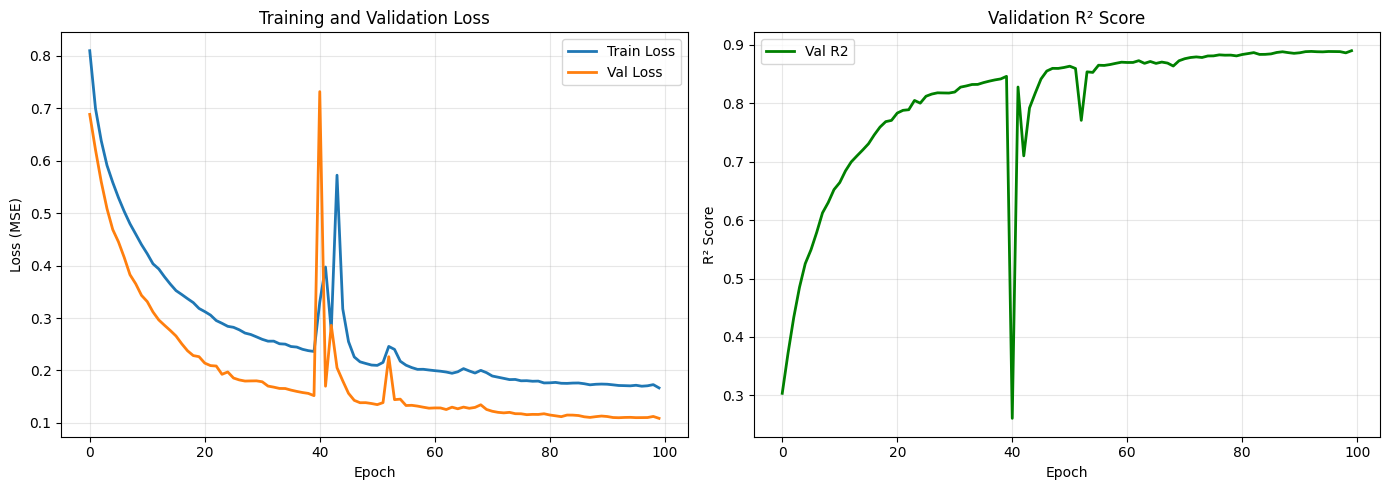


Final Training Loss: 0.1667
Final Validation Loss: 0.1087
Final Validation R²: 0.8898


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot R2 score
axes[1].plot(history['val_r2'], label='Val R2', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Validation R² Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Validation R²: {history['val_r2'][-1]:.4f}")

## Step 7: Evaluate on Test Set

Load best model and evaluate on held-out test data.

In [10]:
# Load best model
model.load_state_dict(torch.load('best_bigru_model.pth'))
model.eval()

# Evaluate on test set
test_loss = 0.0
all_test_preds = []
all_test_targets = []

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

with torch.no_grad():
    for sequences, airtime_feats, ratings in test_loader:
        sequences = sequences.to(device)
        airtime_feats = airtime_feats.to(device)
        ratings = ratings.to(device)

        predictions = model(sequences, airtime_feats)
        loss = criterion(predictions, ratings)
        test_loss += loss.item()

        all_test_preds.extend(predictions.cpu().numpy())
        all_test_targets.extend(ratings.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_r2 = r2_score(all_test_targets, all_test_preds)
test_mse = mean_squared_error(all_test_targets, all_test_preds)
test_rmse = np.sqrt(test_mse)

# Denormalize predictions for interpretability
all_test_preds_denorm = scaler_ratings.inverse_transform(np.array(all_test_preds).reshape(-1, 1)).flatten()
all_test_targets_denorm = scaler_ratings.inverse_transform(np.array(all_test_targets).reshape(-1, 1)).flatten()

# Calculate metrics on original scale
test_r2_denorm = r2_score(all_test_targets_denorm, all_test_preds_denorm)
test_mse_denorm = mean_squared_error(all_test_targets_denorm, all_test_preds_denorm)
test_rmse_denorm = np.sqrt(test_mse_denorm)

print(f"\nNormalized Metrics:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MSE: {test_mse:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}")

print(f"\nOriginal Scale Metrics:")
print(f"  Test R²: {test_r2_denorm:.4f}")
print(f"  Test MSE: {test_mse_denorm:.4f}")
print(f"  Test RMSE: {test_rmse_denorm:.4f}")
print(f"  Mean Absolute Error: {np.mean(np.abs(all_test_targets_denorm - all_test_preds_denorm)):.4f}")


TEST SET EVALUATION

Normalized Metrics:
  Test Loss: 0.1035
  Test R²: 0.8968
  Test MSE: 0.1036
  Test RMSE: 0.3218

Original Scale Metrics:
  Test R²: 0.8968
  Test MSE: 0.0906
  Test RMSE: 0.3009
  Mean Absolute Error: 0.1998


## Step 8: Prediction vs Actual Visualization

Compare model predictions with actual ratings on the test set.

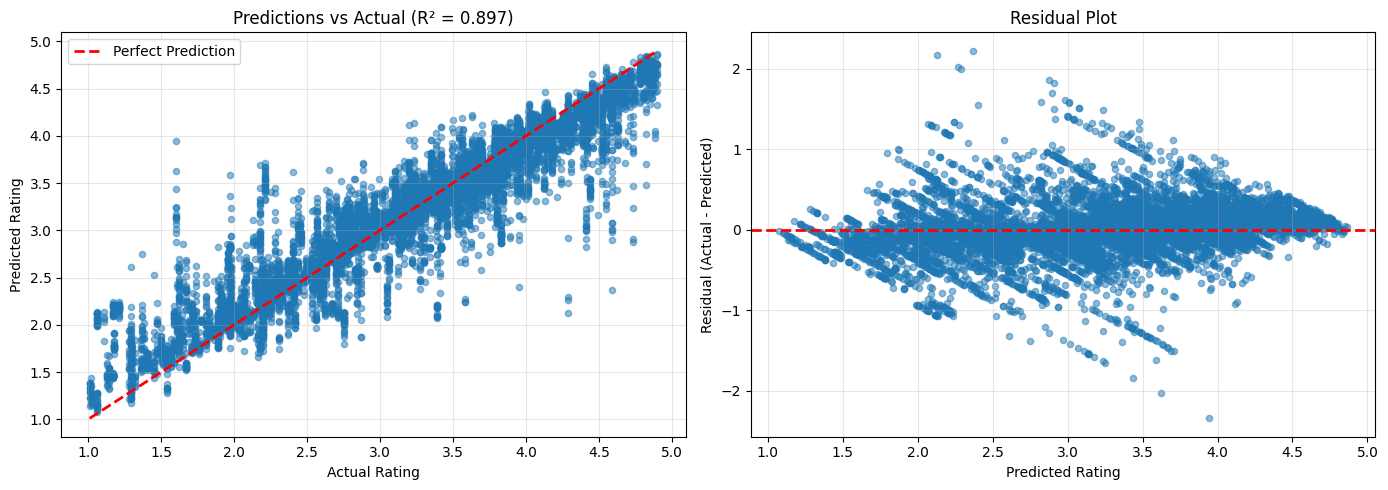


SAMPLE PREDICTIONS
Actual: 1.17 | Predicted: 1.48 | Error: 0.31
Actual: 2.31 | Predicted: 2.14 | Error: 0.17
Actual: 3.63 | Predicted: 3.54 | Error: 0.09
Actual: 1.71 | Predicted: 2.03 | Error: 0.32
Actual: 4.30 | Predicted: 4.15 | Error: 0.15
Actual: 2.71 | Predicted: 2.30 | Error: 0.41
Actual: 4.45 | Predicted: 3.89 | Error: 0.56
Actual: 1.50 | Predicted: 1.73 | Error: 0.23
Actual: 1.13 | Predicted: 1.60 | Error: 0.47
Actual: 4.04 | Predicted: 3.96 | Error: 0.08


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(all_test_targets_denorm, all_test_preds_denorm, alpha=0.5, s=20)
axes[0].plot([min(all_test_targets_denorm), max(all_test_targets_denorm)],
             [min(all_test_targets_denorm), max(all_test_targets_denorm)],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Predictions vs Actual (R² = {test_r2_denorm:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = all_test_targets_denorm - all_test_preds_denorm
axes[1].scatter(all_test_preds_denorm, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Rating')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some example predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)
sample_indices = np.random.choice(len(all_test_targets_denorm), min(10, len(all_test_targets_denorm)), replace=False)
for idx in sample_indices:
    actual = all_test_targets_denorm[idx]
    predicted = all_test_preds_denorm[idx]
    error = abs(actual - predicted)
    print(f"Actual: {actual:.2f} | Predicted: {predicted:.2f} | Error: {error:.2f}")

## Step 9: Save Model and Scalers

Save the trained model and scalers for future use.

In [12]:
import pickle

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'accel_input_size': ACCEL_CHANNELS,
        'airtime_feature_size': AIRTIME_FEATURE_COUNT,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout_rate': DROPOUT_RATE
    },
    'train_config': {
        'sequence_length': SEQUENCE_LENGTH,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    }
}, 'bigru_rating_model.pth')

# Save scalers
with open('scaler_airtime.pkl', 'wb') as f:
    pickle.dump(scaler_airtime, f)

with open('scaler_ratings.pkl', 'wb') as f:
    pickle.dump(scaler_ratings, f)

print("\n" + "="*70)
print("MODEL SAVED")
print("="*70)
print("Files saved:")
print("  - bigru_rating_model.pth (model weights + config)")
print("  - scaler_airtime.pkl (airtime feature scaler)")
print("  - scaler_ratings.pkl (rating scaler)")
print("\nTo load the model:")
print("  checkpoint = torch.load('bigru_rating_model.pth')")
print("  model = BiGRURegressor(**checkpoint['model_config'])")
print("  model.load_state_dict(checkpoint['model_state_dict'])")


MODEL SAVED
Files saved:
  - bigru_rating_model.pth (model weights + config)
  - scaler_airtime.pkl (airtime feature scaler)
  - scaler_ratings.pkl (rating scaler)

To load the model:
  checkpoint = torch.load('bigru_rating_model.pth')
  model = BiGRURegressor(**checkpoint['model_config'])
  model.load_state_dict(checkpoint['model_state_dict'])


In [15]:
import torch
import pickle
from google.colab import drive
import os

# --- 1. MOUNT GOOGLE DRIVE ---
# This line will prompt you to authenticate your Google Drive access.
drive.mount('/content/drive')

# --- 2. DEFINE THE SAVE PATH ---
# Define a path to a folder in your Google Drive.
# We'll use 'colab_saves' within 'My Drive' as an example.
DRIVE_SAVE_DIR = '/content/drive/My Drive/colab_saves/'

# Create the folder if it doesn't already exist
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

# Define the full path for the model file
MODEL_PATH = DRIVE_SAVE_DIR + 'bigru_rating_model.pth'
SCALER_AIRTIME_PATH = DRIVE_SAVE_DIR + 'scaler_airtime.pkl'
SCALER_RATINGS_PATH = DRIVE_SAVE_DIR + 'scaler_ratings.pkl'

# --- 3. SAVE MODEL TO DRIVE ---
# Note: Ensure 'model', 'ACCEL_CHANNELS', 'AIRTIME_FEATURE_COUNT', 'HIDDEN_DIM',
# 'NUM_LAYERS', 'DROPOUT_RATE', 'SEQUENCE_LENGTH', 'BATCH_SIZE',
# 'LEARNING_RATE', and 'NUM_EPOCHS' are defined in your environment.
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'accel_input_size': ACCEL_CHANNELS,
        'airtime_feature_size': AIRTIME_FEATURE_COUNT,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout_rate': DROPOUT_RATE
    },
    'train_config': {
        'sequence_length': SEQUENCE_LENGTH,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    }
}, MODEL_PATH)

# --- 4. SAVE SCALERS TO DRIVE ---
# Note: Ensure 'scaler_airtime' and 'scaler_ratings' are defined.
# Save scalers
with open(SCALER_AIRTIME_PATH, 'wb') as f:
    pickle.dump(scaler_airtime, f)

with open(SCALER_RATINGS_PATH, 'wb') as f:
    pickle.dump(scaler_ratings, f)

# --- 5. CONFIRMATION MESSAGE ---
print("\n" + "="*70)
print("**MODEL AND SCALERS SAVED TO GOOGLE DRIVE**")
print("="*70)
print(f"Files saved in: **{DRIVE_SAVE_DIR}**")
print(f"  - Model: {os.path.basename(MODEL_PATH)}")
print(f"  - Airtime Scaler: {os.path.basename(SCALER_AIRTIME_PATH)}")
print(f"  - Ratings Scaler: {os.path.basename(SCALER_RATINGS_PATH)}")
print("\nTo load the model in a new session, you'll also need to mount Drive first, then use the following path:")
print(f"  checkpoint = torch.load('{MODEL_PATH}')")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

**MODEL AND SCALERS SAVED TO GOOGLE DRIVE**
Files saved in: **/content/drive/My Drive/colab_saves/**
  - Model: bigru_rating_model.pth
  - Airtime Scaler: scaler_airtime.pkl
  - Ratings Scaler: scaler_ratings.pkl

To load the model in a new session, you'll also need to mount Drive first, then use the following path:
  checkpoint = torch.load('/content/drive/My Drive/colab_saves/bigru_rating_model.pth')


In [14]:
checkpoint = torch.load('bigru_rating_model.pth')
model = BiGRURegressor(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>